In [32]:
# Dependencies

import tweepy
from itertools import cycle, islice
from datetime import tzinfo, timedelta, datetime, timezone
import json
import pandas as pd
import matplotlib.pyplot as plt
import pprint as pprint
from config import consumer_key, consumer_secret, access_token, access_token_secret
# Your Twitter API Keys


# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [33]:
#news organizations: BBC, CBS, CNN, Fox, and New York times.
organization_list=["BBC", "CBS", "CNN", "FoxNews","nytimes"]
screen_names=[]
time=[]

# Target User Account
tweets_full=[]
# Variables for holding sentiments
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
tweet_counter=0
tweets_ago=[]
# Number of tweets to retrieve
n_tweets = 100
for organization in organization_list:
    
    for status in tweepy.Cursor(api.user_timeline, id=organization,result_type="recent", tweet_mode='extended').items(n_tweets):
        tweet = status._json
        screen_names.append(tweet["user"]["screen_name"])
        
        tweets_full.append(tweet["full_text"])
        
        vs = analyzer.polarity_scores(tweet["full_text"])
        compound_list.append(vs["compound"])
        positive_list.append(vs["pos"])
        negative_list.append(vs["neg"])
        neutral_list.append(vs["neu"])
        raw_time = tweet["created_at"]
        converted_time=datetime.strptime(raw_time, "%a %b %d %H:%M:%S %z %Y")
        time.append(converted_time)
        tweet_counter=tweet_counter+1 
        tweets_ago.append(tweet_counter)
        if tweet_counter==n_tweets:
                tweet_counter=0
        


In [34]:
#make data frame for data
tweets_dict={"Screen_Name":screen_names,"Tweets":tweets_full,"Compound_Score":compound_list,"Positive_Score":positive_list
            ,"Negative_Score":negative_list,"Neutral_Score":neutral_list,"Time":time,"Tweets_Ago":tweets_ago}
tweets_df=pd.DataFrame(tweets_dict)
tweets_df.to_csv("all_tweets.csv")
tweets_df.head()

,Compound_Score,Negative_Score,Neutral_Score,Positive_Score,Screen_Name,Time,Tweets,Tweets_Ago
0,0.0000,0.0,1.000,0.000,BBC,2018-04-09 16:26:04+00:00,The latest episode of @TheSimpsons has address...,1
1,0.6239,0.0,0.494,0.506,BBC,2018-04-09 16:04:04+00:00,🏃‍♀️❤️ What a brilliant idea! https://t.co/QUV...,2
2,0.4003,0.0,0.856,0.144,BBC,2018-04-09 15:42:30+00:00,RT @BBCTheOneShow: Tonight on The One Show - @...,3
3,0.5411,0.0,0.811,0.189,BBC,2018-04-09 15:29:26+00:00,RT @BBCSport: What a way to save match point!\...,4
4,0.5267,0.0,0.793,0.207,BBC,2018-04-09 15:07:08+00:00,🐶❤️😽\nHenry and Baloo: Dog and cat travel comp...,5


In [35]:
#make data frame for compound score average based on screen_name(news outlet)
compound_news_df=tweets_df.groupby("Screen_Name").mean()
compound_news_df=compound_news_df.reset_index()

del compound_news_df["Negative_Score"]
del compound_news_df["Neutral_Score"]
del compound_news_df["Positive_Score"]
del compound_news_df["Tweets_Ago"]
compound_news_df.to_csv("Average_Compound_Score.csv")
compound_news_df.head()

,Screen_Name,Compound_Score
0,BBC,0.104611
1,CBS,0.431428
2,CNN,-0.213041
3,FoxNews,-0.131994
4,nytimes,0.053217


In [61]:
#see how many counts are negative 
(tweets_df["Compound_Score"]<=0).value_counts()


True     297
False    203
Name: Compound_Score, dtype: int64

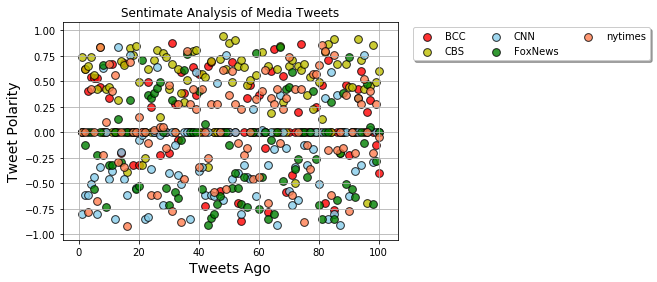

In [36]:
#create data frame for each news outlet and plot in scatterplot for all tweet sentament 
BBC= tweets_df[tweets_df["Screen_Name"] == "BBC"]
CBS=tweets_df[tweets_df["Screen_Name"]== "CBS"]
CNN=tweets_df[tweets_df["Screen_Name"]== "CNN"]
FoxNews=tweets_df[tweets_df["Screen_Name"]== "FoxNews"]
nytimes=tweets_df[tweets_df["Screen_Name"]== "nytimes"]

plt.scatter(BBC["Tweets_Ago"], 
            BBC["Compound_Score"], 
             c="r",s=60,
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="BCC")

plt.scatter(CBS["Tweets_Ago"], 
            CBS["Compound_Score"], 
             c="y", s=60,
            edgecolor="black", linewidths=1, marker="o", 
              alpha=0.8, label="CBS")
plt.scatter(CNN["Tweets_Ago"], 
            CNN["Compound_Score"], 
             c="skyblue", s=60,
            edgecolor="black", linewidths=1, marker="o", 
              alpha=0.8, label="CNN")
plt.scatter(FoxNews["Tweets_Ago"], 
            FoxNews["Compound_Score"], 
             c="g", s=60,
            edgecolor="black", linewidths=1, marker="o", 
              alpha=0.8, label="FoxNews")
plt.scatter(nytimes["Tweets_Ago"], 
            nytimes["Compound_Score"], 
             c="coral", s=60,
            edgecolor="black", linewidths=1, marker="o", 
              alpha=0.8, label="nytimes")
plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1.),
          ncol=3, fancybox=True, shadow=True)
plt.title("Sentimate Analysis of Media Tweets")        
plt.xlabel("Tweets Ago", size=14)
plt.ylabel("Tweet Polarity",size=14)
plt.grid()
plt.savefig('Seperate_Sentimate_Analysis.jpeg', bbox_inches='tight')
plt.show()


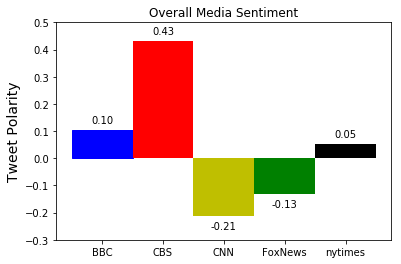

In [37]:
#create and label bar graph for average sentiment
ax= plt.bar(compound_news_df["Screen_Name"], compound_news_df["Compound_Score"],width=1,edgecolor="b" ,color=("b","r","y","g","k"))
plt.ylim(-0.3,0.5)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.2f}".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
plt.title("Overall Media Sentiment")        
plt.ylabel("Tweet Polarity",size=14)
plt.savefig('Average_Overall_Sentimate_Analysis.jpeg', bbox_inches='tight')
plt.show()
